# Prédiction catégorielle

*Authors : Théo Duquesne, Taliesine Gueye, Navarre Victor et Benjamin Pineau*

Nos données comportent des variables catégorielles. Il peut alors être intéressant d'éssayer d'utiliser un algorithme d'**Expectation Maximisation** sur des variables catégorielles plutot que sur des variables continues

**Attention** Des données sont continues (comme la température ou le rayon par exemple). Il faudra trouver un moyen pertinent de les "rendre" catégorielles

In [196]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rnd
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from skimage import io
from PIL import Image
from io import BytesIO
import requests
from skimage.util import view_as_windows
from stepmix.stepmix import StepMix

In [197]:
# Importation des données
star_data = pd.read_csv ('data_star.csv')

Idée pour transformer les variables continues en variables catégorielles : on trace les histogrammes pour observer la distribution et remarquer (ou non) si l'on peut regrouper les données dans différentes classes

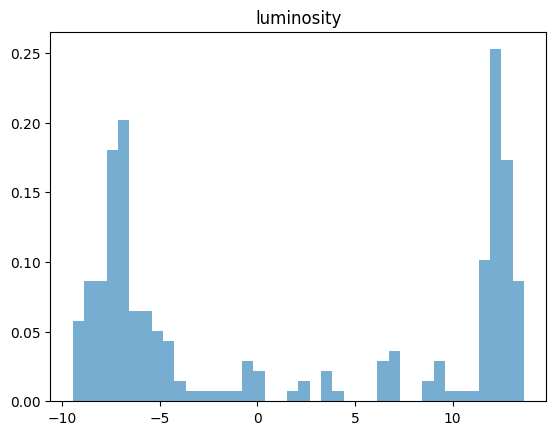

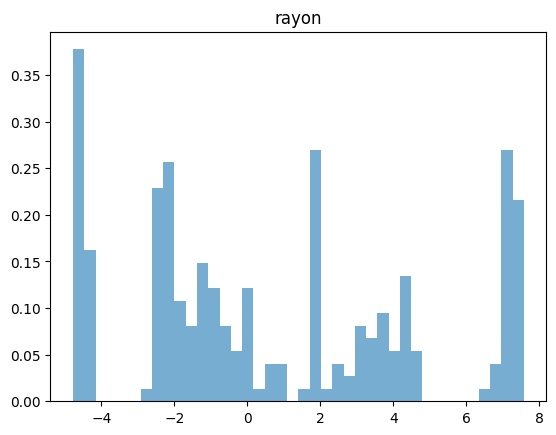

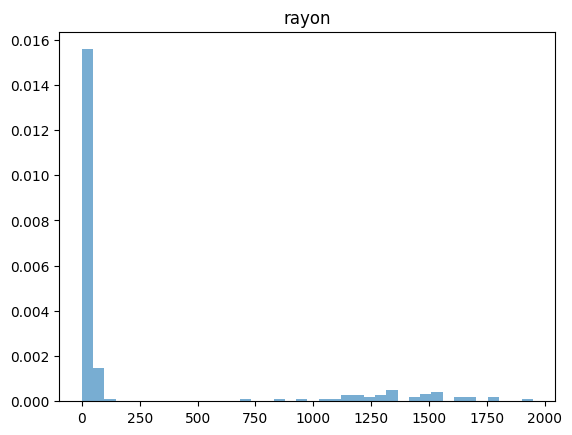

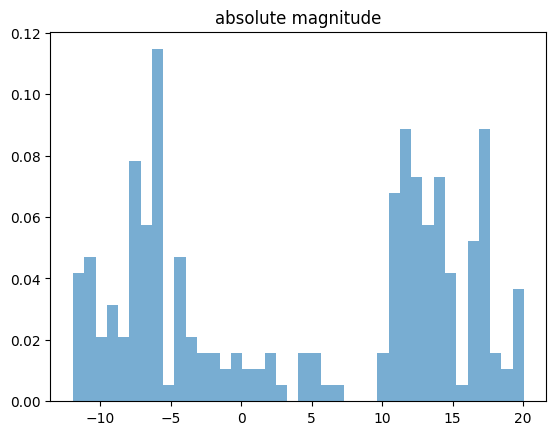

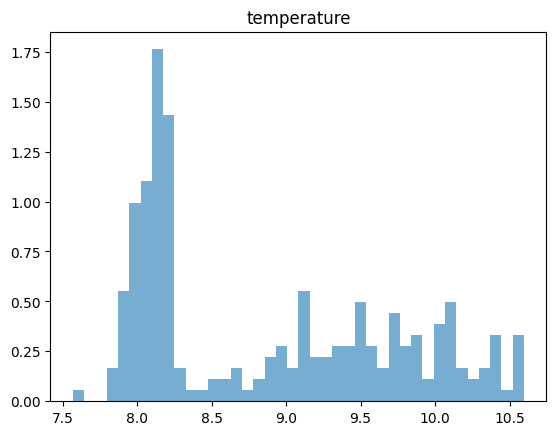

In [198]:
# Modification des données pour avoir des variables catégorielles

plt.hist(np.log(star_data["Luminosity (L/Lo)"]), density = True, alpha = 0.6, bins = 40)
plt.title('luminosity')
plt.show()
plt.hist(np.log(star_data["Radius (R/Ro)"]), density = True, alpha = 0.6, bins = 40)
plt.title('rayon')
plt.show()
plt.hist(star_data["Radius (R/Ro)"], density = True, alpha = 0.6, bins = 40)
plt.title('rayon')
plt.show()
plt.hist(star_data["Absolute magnitude (Mv)"], density = True, alpha = 0.6, bins = 40)
plt.title('absolute magnitude')
plt.show()
plt.hist(np.log(star_data["Temperature (K)"]), density = True, alpha = 0.6, bins = 40)
plt.title('temperature')
plt.show()

In [199]:
# categorisation pour le rayon

condition_rayon = [
    np.log(star_data["Radius (R/Ro)"]) < 0,
    ((np.log(star_data["Radius (R/Ro)"]) >= 0) & (np.log(star_data["Radius (R/Ro)"]) <= 4)),
    np.log(star_data["Radius (R/Ro)"]) > 4
]

categories_rayon = [-1, 0, 1]

star_data["Radius categ"] = np.select(condition_rayon, categories_rayon)
print(star_data[['Radius categ']].value_counts())

Radius categ
-1              127
 1               58
 0               55
Name: count, dtype: int64


In [200]:
# categorisation pour la luminosité 

condition_lum = [
    np.log(star_data["Luminosity (L/Lo)"]) < -4,
    ((np.log(star_data["Luminosity (L/Lo)"]) >= -4) & (np.log(star_data["Luminosity (L/Lo)"]) <= 8)),
    np.log(star_data["Luminosity (L/Lo)"]) > 8
]

categories_lum = [-2, 0, 3]

star_data["Luminosity categ"] = np.select(condition_lum, categories_lum)
print(star_data[['Luminosity categ']].value_counts())

Luminosity categ
-2                  116
 3                   94
 0                   30
Name: count, dtype: int64


In [201]:
# categorisation pour absolute magnitude

condition_mag = [
    star_data["Absolute magnitude (Mv)"] < -5,
    (star_data["Absolute magnitude (Mv)"] >= -5) & (star_data["Absolute magnitude (Mv)"] <= 10),
    (star_data["Absolute magnitude (Mv)"] >= 10) & (star_data["Absolute magnitude (Mv)"] <= 15),
    star_data["Absolute magnitude (Mv)"] > 15
]

categories_mag = [-2, 0, 3, 5]

star_data["Abs mag categ"] = np.select(condition_mag, categories_mag)
print(star_data[['Abs mag categ']].value_counts())

Abs mag categ
-2               80
 3               80
 0               40
 5               40
Name: count, dtype: int64


In [202]:
# categorisation pour la temperature

condition_temp = [
    np.log(star_data["Temperature (K)"]) < 8.5,
    np.log(star_data["Temperature (K)"]) > 8.5
]

categories_temp = [0, 1]

star_data["Temp categ"] = np.select(condition_temp, categories_temp)
print(star_data[['Temp categ']].value_counts())

Temp categ
1             125
0             115
Name: count, dtype: int64


In [203]:
# categorisation de la couleur 
print(star_data[["Star color"]].value_counts())

Star color  
Red             112
Blue             56
Blue White       41
Yellow White     13
White            12
Yellowish         3
Orange            2
Orange Red        1
Name: count, dtype: int64


In [204]:
# conversion de la classe couleur en int
condition_couleur = [
    star_data["Star color"] == "Red",
    star_data["Star color"] == "Blue",
    star_data["Star color"] == "Blue White",
    star_data["Star color"] == "Yellow White",
    star_data["Star color"] == "White",
    star_data["Star color"] == "Yellowhish",
    star_data["Star color"] == "Orange",
    star_data["Star color"] == "Orange Red",
]

# on ordonne selon la longueur d'onde
categories_couleur = [10, 4, 3, 1, 0, 2, 8, 9]

star_data["Couleur categ"] = np.select(condition_couleur, categories_couleur)
print(star_data[['Couleur categ']].value_counts())

Couleur categ
10               112
4                 56
3                 41
0                 15
1                 13
8                  2
9                  1
Name: count, dtype: int64


In [205]:
star_data.replace({'Spectral Class':{'M':0, 'A':4, 'B':5, 'F':3, 'O':7, 'K':1, 'G':2 }}, inplace = True)

/var/folders/vv/yd9tg_vd01b85m5mbpmc1v3r0000gn/T/ipykernel_41733/486762352.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  star_data.replace({'Spectral Class':{'M':0, 'A':4, 'B':5, 'F':3, 'O':7, 'K':1, 'G':2 }}, inplace = True)


In [206]:
# on supprime les colonnes de variables continues
star_data_model = star_data.drop(columns = ['Star category'])
star_data_model = star_data_model.drop(columns = ['Luminosity (L/Lo)'])
star_data_model = star_data_model.drop(columns = ['Radius (R/Ro)'])
star_data_model = star_data_model.drop(columns = ['Absolute magnitude (Mv)'])
star_data_model = star_data_model.drop(columns = ['Star color'])
star_data_model = star_data_model.drop(columns = ['Spectral Class'])
star_data_model = star_data_model.drop(columns = ['Temperature (K)'])

print(star_data_model)

     Star type  Radius categ  Luminosity categ  Abs mag categ  Temp categ  \
0            0            -1                -2              5           0   
1            0            -1                -2              5           0   
2            0            -1                -2              5           0   
3            0            -1                -2              5           0   
4            0            -1                -2              5           0   
..         ...           ...               ...            ...         ...   
235          5             1                 3             -2           1   
236          5             1                 3             -2           1   
237          5             1                 3             -2           1   
238          5             1                 3             -2           1   
239          5             1                 3             -2           1   

     Couleur categ  
0               10  
1               10  
2           

In [207]:
# prediction avec melange gaussien categoriel

model_categ = StepMix(n_components = 6, measurement="categorical")
model_categ.fit(star_data_model)

Y_pred_bic = model_categ.predict(star_data_model)
print(Y_pred_bic)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 30.66it/s, max_LL=-789, max_avg_LL=-3.29]

[2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 3 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4
 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 5 5 5 5
 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0
 0 0 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [208]:
star_data['prediction class'] = Y_pred_bic

In [209]:
classe_array = np.array(star_data['Star category'])
Y_pred_array = np.array(Y_pred_bic)
df = pd.DataFrame({
    'prediction' : Y_pred_array,
    'classe' : classe_array
})
print(df)
df.to_csv("prediction_classes.csv", index=False)

     prediction       classe
0             2  Brown Dwarf
1             2  Brown Dwarf
2             2  Brown Dwarf
3             2  Brown Dwarf
4             2  Brown Dwarf
..          ...          ...
235           1   Hypergiant
236           1   Hypergiant
237           1   Hypergiant
238           1   Hypergiant
239           1   Hypergiant

[240 rows x 2 columns]


In [210]:
from sklearn.metrics import confusion_matrix

df = pd.read_csv("prediction_classes.csv")
true_labels = df['classe'].astype('category').cat.codes
pred_labels = df['prediction']

cm = confusion_matrix(true_labels, pred_labels)
print("Matrice de confusion :\n", cm)

Matrice de confusion :
 [[ 0  0 40  0  0  0]
 [ 0 40  0  0  0  0]
 [ 0  0  0  0 40  0]
 [ 0  0  0  0  0 40]
 [ 0 40  0  0  0  0]
 [39  0  0  1  0  0]]
